# 深層学習体験会: 画像分類（コンテンツ判定）

このノートブックでは、**画像分類モデル**を使って、画像の内容を自動的に判定する方法を学びます。

## 画像分類とは？

画像分類とは、画像を見て、その画像がどのカテゴリーに属するかを判定するAI技術です。画像分類といっても様々な分類方法はありますが、このノートブックでは、画像が一般的なコンテンツか、職場では不適切な内容（NSFW: Not Safe For Work）かを判定する二値分類モデルを使用します。

### 応用例
- SNSのコンテンツモデレーション
- 画像検索エンジンのフィルタリング
- オンラインプラットフォームの安全性確保
- 家族向けサービスのコンテンツ管理

## このノートブックの流れ
1. 必要なライブラリのインストール
2. Google Driveの接続
3. 画像分類モデルの読み込み
4. 画像の判定と結果の表示

## ステップ1: 必要なライブラリのインストール

画像分類に必要な`transformers`ライブラリをインストールします。

In [ ]:
!pip install transformers japanize-matplotlib

## ステップ2: Google Driveの接続とフォルダ作成

Google Driveに接続して、判定したい画像を保存するフォルダを作成します。

In [ ]:
# Google Driveをマウント（接続）する
from google.colab import drive
import os

# Google Driveに接続（初回は認証が必要です）
drive.mount('/content/drive')

# 画像を保存するディレクトリのパス
images_dir = "/content/drive/MyDrive/images"

# ディレクトリが存在しない場合は作成する（exist_ok=Trueで既存の場合はエラーにしない）
os.makedirs(images_dir, exist_ok=True)

# 画像を保存するディレクトリのパス
images_dir = "/content/drive/MyDrive/images/02"

# ディレクトリが存在しない場合は作成する（exist_ok=Trueで既存の場合はエラーにしない）
os.makedirs(images_dir, exist_ok=True)

# 作成完了メッセージを表示
print("✅ フォルダ作成:", images_dir)

## ステップ3: 画像分類モデルの読み込み

ここでは、**NSFW画像検出モデル**を読み込みます。このモデルは、画像が一般的な内容（normal）か、職場では不適切な内容（nsfw）かを判定します。

### 使用するモデル
- **モデル名**: Falconsai/nsfw_image_detection
- **アーキテクチャ**: Vision Transformer (ViT)
- **機能**: 2クラス分類（normal / nsfw）

モデルの構造は以下のようになっています。画像を16x16の小区画にパッチ分けし、それをベクトル列だと思って自然言語処理系のモデルであるTransformerを用いて処理を行います。

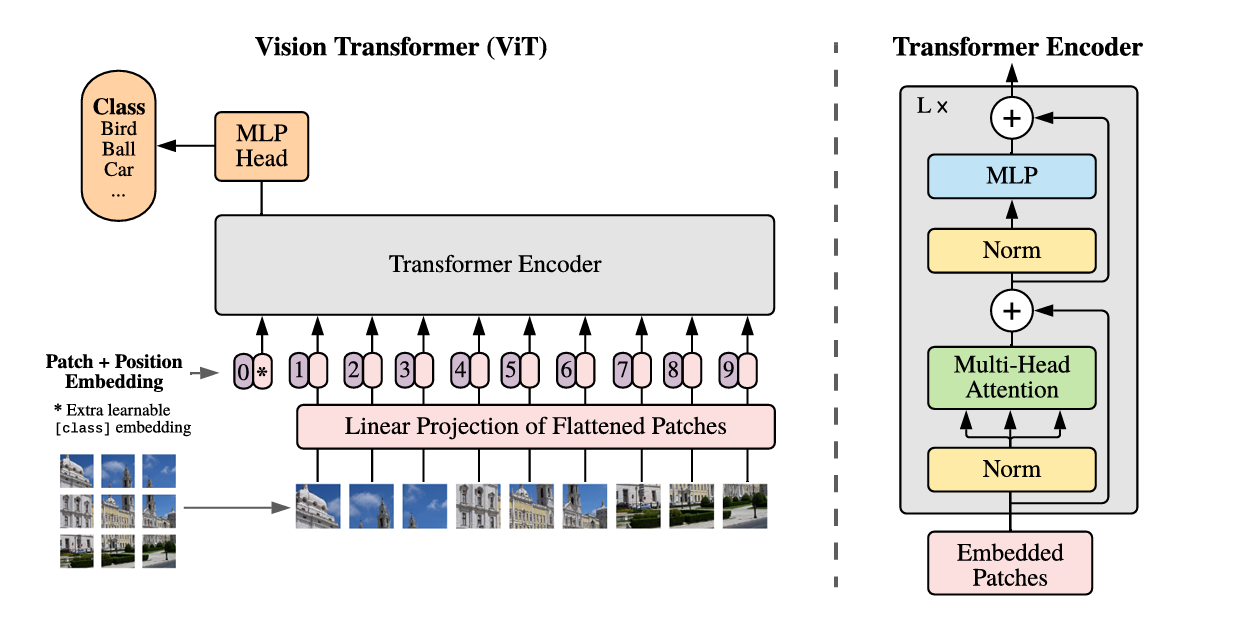

In [ ]:
# 必要なライブラリをインポート
import torch  # PyTorch（ディープラーニングフレームワーク）
from PIL import Image  # 画像処理用ライブラリ
from transformers import AutoConfig, AutoModelForImageClassification, ViTImageProcessor  # Hugging Faceのモデル

# NSFW画像検出モデルを読み込む
# AutoModelForImageClassification: 画像分類用のモデルを自動で読み込む
# from_pretrained: 事前学習済みモデルをダウンロードして読み込む
model = AutoModelForImageClassification.from_pretrained("Falconsai/nsfw_image_detection")

# 画像プロセッサ（画像を前処理する）を読み込む
# ViTImageProcessor: Vision Transformer用の画像処理
processor = ViTImageProcessor.from_pretrained('Falconsai/nsfw_image_detection')

In [ ]:
print(processor)

## 各項目の意味

### `"do_resize": true`

画像をリサイズする。
→ `size` の設定に従って、**224×224ピクセル** に変換。

### `"size": {"height": 224, "width": 224}`

リサイズ後の最終的な画像サイズ（ViT が 224x224 を想定しているため）。
元画像が異なるアスペクト比でも、通常は**短辺基準でリサイズ＋中心クロップ**が行われる。

### `"resample": 2`

リサイズ時の補間方法。
`2` は **PIL.Image.BILINEAR**（バイリニア補間）を意味する。

### `"do_rescale": true`

画像を 0–255 の範囲から **0–1 にスケーリング**する。つまり255で割る。

### `"do_normalize": true`

スケーリング後に**平均・標準偏差による正規化**を行う設定。

### `"image_mean": [0.5, 0.5, 0.5]`

### `"image_std": [0.5, 0.5, 0.5]`

RGB 各チャンネルに対して、次の式で正規化：

[
\text{normalized} = \frac{(x - 0.5)}{0.5} = 2x - 1
]

つまり、最終的に各ピクセル値は **[-1, 1]** の範囲に変換される。

### `"do_convert_rgb": null`

明示的な指定なし（`null` → 既定では True）。
→ 入力画像を **RGB に変換**する（モノクロやRGBAのままではなく、RGB 3チャンネルに揃える）。


In [ ]:
# モデルの設定ファイルを取得
config = AutoConfig.from_pretrained("Falconsai/nsfw_image_detection")
# 設定内容を表示
print(config)

## 各項目の意味

## 入力方法

* **image_size:** `224`
  入力画像は **224×224** 。

* **num_channels:** `3`
  入力が **RGB**（3チャンネル）。

* **patch_size:** `16`
  画像を **16×16 のパッチ**に分割して埋め込み。
  224/16=14 → **14×14=196** パッチ + `[CLS]` トークン = **197トークン**の系列長。

## Transformer本体（バックボーン）

* **hidden_size:** `768`
  トークン埋め込みの次元。つまり入力データの形状は197x768

* **num_hidden_layers:** `12`
  Transformer エンコーダブロック（Self-Attn + MLP）の**段数**。

* **num_attention_heads:** `12`
  マルチヘッド注意のヘッド数。
  `head_dim = hidden_size / heads = 768/12 = 64`。

* **intermediate_size:** `3072`
  各ブロックの MLP 内部次元（FFNの中間層）。典型的に `4×hidden_size`。

* **hidden_act:** `"gelu"`
  FFNで使う活性化関数。

* **qkv_bias:** `true`
  Self-Attention の **Q/K/V 変換線形層にバイアス**を入れるかどうか（True だと若干表現力↑、パラメータもわずかに↑）。

* **layer_norm_eps:** `1e-12`
  LayerNorm の数値安定用イプシロン。

* **attention_probs_dropout_prob:** `0.0`
  アテンションの確率（softmax出力）にかかるドロップアウト率。**0**＝ドロップしない（推論では通常無効だが、学習時の正則化に関わる）。

* **hidden_dropout_prob:** `0.0`
  埋め込み・FFN出力にかかるドロップアウト率。**0**＝なし。

---

## ステップ4: 画像の判定と結果の表示

Google Driveにアップロードした画像を読み込み、AIモデルで判定します。

### このコードの機能
1. **画像の読み込み**: 指定したパスから画像を読み込む
2. **推論の実行**: モデルが画像を判定
3. **色反転オプション**: `is_inverted`フラグで画像を反転表示できる
4. **結果の表示**: 判定結果（normal / nsfw）と画像を表示

### 使い方
1. Google Driveの`/MyDrive/images/`フォルダに判定したい画像をアップロード
2. 画像のファイル名を確認してコードを実行
3. `is_inverted = True`にすると、色を反転した画像が表示されます

In [ ]:
# 必要なライブラリをインポート
from PIL import Image, ImageOps  # 画像処理用
import matplotlib.pyplot as plt  # グラフ・画像表示用
import japanize_matplotlib


# --- 対象ディレクトリ ---
img_dir = "/content/drive/MyDrive/images/02"

# --- 対応する拡張子を指定 ---
valid_exts = [".png", ".jpg", ".jpeg", ".bmp", ".webp"]

# --- ディレクトリ内の画像を走査 ---
for filename in sorted(os.listdir(img_dir)):
    if not any(filename.lower().endswith(ext) for ext in valid_exts):
        continue  # 対象外のファイルはスキップ

    img_path = os.path.join(img_dir, filename)
    img = Image.open(img_path).convert("RGB")

    # --- 推論 ---
    with torch.no_grad():
        inputs = processor(images=img, return_tensors="pt")
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_label = logits.argmax(-1).item()
        label = model.config.id2label[predicted_label]

    # --- 判定と表示処理 ---
    if label != "normal":  # nsfw判定時
        display_img = ImageOps.invert(img)
        title_text = f"⚠️ NSFW: {filename}"
        print(f"{filename} → NSFW（反転表示）")
    else:
        display_img = img
        title_text = f"OK: {filename}"
        print(f"{filename} → normal")

    # --- 画像を表示 ---
    plt.figure(figsize=(5, 5))
    plt.title(title_text)
    plt.imshow(display_img)
    plt.axis("off")
    plt.show()